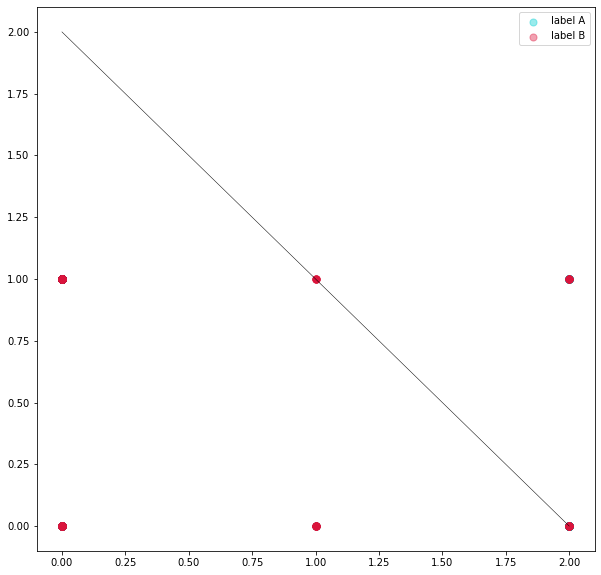

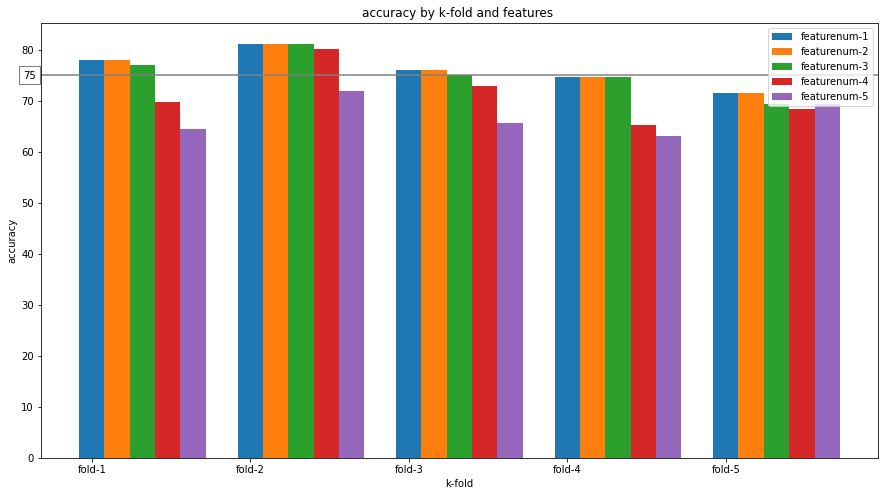

In [3]:
from sklearn import linear_model, datasets
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
from Logistic import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score
from random import choice
import numpy as np
from sklearn.model_selection import KFold
import heapq
import matplotlib.pyplot as plt
from numpy import *

savepath = "D:/WorkSpace/Shell/DataMining/result/"
##加载数据
def loadCSVfile2(filepath,labelstr,featurestr):
    odata = pd.read_csv(filepath)
    label = odata[labelstr] ##不包括表头
    feature = odata.drop([featurestr], axis=1) #除去label列之外的所有feature值

    return np.array(label).reshape(-1), np.array(feature) #返回array类型的数据

##皮尔森系数
def pearsonFeature(feature, label):

    pearson = abs(np.corrcoef(feature.reshape(-1), label)[0][1])

    return pearson
##标准化
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma

##PCA  做了之后，svm分类效果变差
def PCA_Featrue(feature_list):
    # ##进行PCA分析
    pca = PCA(n_components = 2) #n_components代表保存的特征数
    pca.fit(feature_list)
    low_feature = pca.transform(feature_list)   #降低维度
    print(pca.explained_variance_ratio_)  ##贡献值

    return low_feature


##处理Nan值
def handleNan(feature):

    contain_nan = (True in np.isnan(feature))
    if contain_nan is True:

        index_nan = 0
        for x in feature:##将nan替换为0或1
            if np.isnan(x):
                feature[index_nan] = choice([0, 1])
            index_nan += 1
    return feature

##对特征“wbc”到“size”的异常值0进行处理，使用对应特征列的平均值进行填充
def handlErrorValue(feature_all, feature_select_num):
    feature_list = []
    pearson_list = []
    feature_pearson = []
    for index in range(16):
        feature = feature_all[:,index:1 + index]  #提取特征值列
        ##处理Nan特征值
        feature = handleNan(feature)

        pearson_list.append(pearsonFeature(feature, label))
        #np.place(feature, feature == float(0), feature.mean())  #将特征值为0的替换为平均值  不需要做
        feature_list.append(feature)
    ##挑选pearson系数最高的特征下标
    pearson_index = map(pearson_list.index, heapq.nlargest(feature_select_num, pearson_list))
    pearson_index = list(pearson_index)
    ##将pearson挑选出的最好的特征
    for index in pearson_index:
        feature_pearson.append(feature_list[index])

    #feature_all  = standardization(np.array(feature_pearson).T.reshape(478, feature_select_num)) ##标准化
    feature_all = preprocessing.scale(np.array(feature_pearson).T.reshape(-1, feature_select_num)) ##z-score归一化

    #feature_all = PCA_Featrue(feature_all)
    return feature_all, np.array(feature_pearson).T.reshape(-1, feature_select_num)

##保存结果报告文件
def save_to_file(file_name, contents):
    fh = open(file_name, 'w')
    fh.write(contents)
    fh.close()

##对五折结果进行柱状图的刻画
def histogramPicture(acc_all_list):
     # G1,G2,G3,G4,G5小组的分数。
    labels = ['fold-1', 'fold-2', 'fold-3', 'fold-4', 'fold-5']
    x = np.arange(len(labels))
    width = 0.16  # 柱形图的宽度
    plt.figure(figsize=(15, 8))
    plt.xticks(x, labels)  # 设置具体刻度。
    plt.xlabel('k-fold')  # x轴标签
    plt.ylabel('accuracy')  # y轴标签
    plt.title('accuracy by k-fold and features ')  # 该柱形图的标题
    num = 0
    for acc_list in acc_all_list:
        plt.bar(x + num * width, list(map(float, acc_list[0:5])), width,  label='featurenum-' + str(num + 1))  # 计算出左边柱形图的位置。
        num = num + 1

    plt.axhline(75, color="gray") #画出75%的线
    plt.text(-0.35, 75, "75", va='center', ha="right", bbox=dict(facecolor="w",alpha=0.5))##添加文字
    plt.legend()
    plt.savefig(savepath + "/picture/svm_acc.svg")
    plt.show()


def autolabel(ax,rects):
    """在每个柱形条上方添加一个文本标签，显示高度。"""
    index = 0
    for rect in rects:
        height = rect.get_height()  # 获取柱形条的高度。
        # annotate() 用于在图形上给数据添加文本注解(注释)。
        ax.annotate('{}'.format(height, ".2f"),  # s 注释文本内容
                    xy=(rect.get_x() + rect.get_width() * index, height),  # 被注释的坐标点：xy=(横坐标，纵坐标)，即每个柱形条的顶部中心。
                    xytext=(0, 3),  # 注释文本的坐标点（相对于被注释点取坐标）：xytext(横坐标，纵坐标)。
                    textcoords="offset points",  # 被注释点的坐标系属性：点，像素，百分比等。"offset points"指偏移量，单位：点。
                    ha='center')  # ha='center' 让注解居中
        index = index + 1

def svmTrain(feature_list, label):
    svmmoudle = svm.SVC(kernel='rbf', gamma=10, decision_function_shape='ovr')
    svmmoudle.fit(feature_list, label)
    return svmmoudle

def mean(list):
    sum = 0
    for num in list:
        sum = float(num) + sum
    return format(sum/5, ".2f")
def kFoldGetResult(feature_all, label, feature_num, k_unm):

    accuracy_all_list = []
    for num in range(1,feature_num + 1):## 选择1-5个特征的数据情况下进行训练和测试
        feature_list,feature_list2= handlErrorValue(feature_all, num)
        if num == 2:
            label1_data = np.array(list(map(lambda x: feature_list2[x,:], np.argwhere(label==1)))).reshape(-1, 2)
            label2_data = np.array(list(map(lambda x: feature_list2[x,:], np.argwhere(label==2)))).reshape(-1, 2)
            plotMatrixPoint(label1_data, label2_data)

        kfold = KFold(n_splits = k_unm) #设立五折
        index = 0
        accuracy_list = []
        for train_index, test_index in kfold.split(feature_all): ##进行五折交叉实验
            ##提取训练数据和测试数据
            train_data, test_data = feature_list[train_index], feature_list[test_index]
            train_label, test_label = label[train_index], label[test_index]

            #'使用径向机方法分类'
            svmmoudle = svmTrain(train_data, train_label)
            y_pred_test = svmmoudle.predict(test_data)##计算出测试集的预测值
            acc = accuracy_score(test_label, y_pred_test)###计算正确率
            accuracy_list.append(format(acc * 100,".2f")) ##将五折准确率记录起来
            index = index + 1
        sum = 0

        accuracy_list.append(mean(accuracy_list))
        accuracy_all_list.append(accuracy_list)  ##将选取不同特征得出的结果记录

    return accuracy_all_list





def plotMatrixPoint(data1, data2):
    """
    输入二维点矩阵和标签，能够改变不同形状
    :param Mat:
    :param Label:
    :return:
    """
    plt.figure(figsize=(10, 10))
    colors1 = '#00CED1' #点的颜色
    colors2 = '#DC143C'
    area = np.pi * 4**2  # 点面积
    # 画散点图
    plt.scatter(data1[:,0], data1[:,1], s=area, c=colors1, alpha=0.4, label='label A')
    plt.scatter(data2[:,0], data2[:,1], s=area, c=colors2, alpha=0.4, label='label B')
    plt.plot([0,2],[2,0],linewidth = '0.5',color='#000000')
    plt.legend()
    plt.show()



if __name__ == "__main__":
    ##加载数据
    label, feature_all = loadCSVfile2("train.csv", 'group', 'group')
    #进行5折交叉，将得到的准确率返回 特征个数从1-5
    acc_list = kFoldGetResult(feature_all, label, feature_num=5, k_unm=5)
    save_to_file(savepath + "acc/svm_acc.txt",str(acc_list))
    ##画出K折交叉的图
    histogramPicture(acc_list)